<a href="https://colab.research.google.com/github/zzzzz151/TAA-Project1/blob/master/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")


In [105]:
# Column 1: age in years
# Column 2: 1 = male, 0 = female
# Column 3: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
# Column 4: resting blood pressure in mmHg
# Column 5: in mg/dl
# Column 6: 1 means > 120 mg/dl, 0 means <= 120 mg/dl
# Column 7: resting electrocardiographic, 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
# Column 8: max heart rate achieved
# Column 9: 1 = yes, 2 = no
# Column 10: ST depression induced by exercise relative to rest
# Column 11: slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping
# Column 12: number of major vessels (0-3) colored by flourosopy
# Column 13: 3 = normal, 6 = fixed defect, 7 = reversable defect
# Column 14: >=1 means heart disease, 0 = no heart disease

myNames = ["age", # column 1
        "sex", # col 2
        "chestPainType", # col 3
        "restingBP", # col 4
        "serumCholesterol", # col 5
        "fastingBloodSugar", # col 6
        "restingEcg", # col 7
        "maxHeartRate", # col 8
        "exerciseInducedAngina", # col 9
        "stDepression", # col 10
        "stSlope", # col 11
        "majorVessels", # col 12
        "thalassemia", # col 13
        "diagnosis"] # col 14
assert len(myNames) == 14
data=pd.read_csv("data/processed.cleveland.data", sep=',', names=myNames, na_values=["?", '?'])
data = data.dropna() # Drop rows with missing data
data.iloc[:, -1] = data.iloc[:, -1].clip(0, 1) # clip last column (output) between 0 and 1, both inclusive


# Convert all columns to float
for name in myNames:
    data[name] = pd.to_numeric(data[name],errors = 'coerce')

m = data.shape[0] # num examples
n = data.shape[1] - 1 # num features

print("Num features:", n)
print("Num examples:", m)
    
# a few examples from the dataset 
print()
print(data.head())

X = data.values[:, :-1]
y = data.values[:, -1:]

categoricalColumnsNames = ["sex", 
                      "chestPainType", 
                      "fastingBloodSugar", 
                      "restingEcg", 
                      "exerciseInducedAngina", 
                      "stSlope",
                      "majorVessels",
                      "thalassemia"]
continuousColumns = data.drop(categoricalColumnsNames, axis=1)
continuousColumnsNames = [name for name in myNames if name not in categoricalColumnsNames and name != "diagnosis"]
categoricalColumns = data.drop(continuousColumnsNames, axis=1)
if "diagnosis" in continuousColumns:
    continuousColumns = continuousColumns.drop("diagnosis", axis=1)
if "diagnosis" not in categoricalColumns:
    categoricalColumns = data["diagnosis"]

    # Feature selection
data = data.drop("fastingBloodSugar", axis=1)
myNames.remove("fastingBloodSugar")
data = data.drop("restingEcg", axis=1)
myNames.remove("restingEcg")
data = data.drop("serumCholesterol", axis=1)
myNames.remove("serumCholesterol")
data = data.drop("stSlope", axis=1)
myNames.remove("stSlope")
data = data.drop("restingBP", axis=1)
myNames.remove("restingBP")



Num features: 13
Num examples: 297

    age  sex  chestPainType  restingBP  serumCholesterol  fastingBloodSugar  \
0  63.0  1.0            1.0      145.0             233.0                1.0   
1  67.0  1.0            4.0      160.0             286.0                0.0   
2  67.0  1.0            4.0      120.0             229.0                0.0   
3  37.0  1.0            3.0      130.0             250.0                0.0   
4  41.0  0.0            2.0      130.0             204.0                0.0   

   restingEcg  maxHeartRate  exerciseInducedAngina  stDepression  stSlope  \
0         2.0         150.0                    0.0           2.3      3.0   
1         2.0         108.0                    1.0           1.5      2.0   
2         2.0         129.0                    1.0           2.6      2.0   
3         0.0         187.0                    0.0           3.5      3.0   
4         2.0         172.0                    0.0           1.4      1.0   

   majorVessels  thalassem

In [106]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Normalization
# Binary features do not need normalization as they are already 0 or 1

numeric_features = ['age', "maxHeartRate", "fastingBloodSugar", "stDepression", "majorVessels"]

for f in numeric_features:
    if f not in myNames:
        numeric_features.remove(f)


# Nominal categorical features have no hierarchical order (as opposed to [very healthy, healthy, unhealthy, very unhealthy])
nominal_categorical_features = ["chestPainType", "thalassemia"]

for f in nominal_categorical_features:
    if f not in myNames:
        nominal_categorical_features.remove(f)

data_normalized = data.copy()

scaler = StandardScaler() # or MinMaxScaler()
data_normalized[numeric_features] = scaler.fit_transform(data_normalized[numeric_features])

encoder = OneHotEncoder()
nominal_cat_encoded = encoder.fit_transform(data_normalized[nominal_categorical_features])
nominal_cat_encoded = pd.DataFrame(nominal_cat_encoded.toarray(), columns=encoder.get_feature_names_out(nominal_categorical_features))

data_normalized = pd.concat([data_normalized.drop(nominal_categorical_features, axis=1), nominal_cat_encoded], axis=1)
data_normalized = data_normalized.dropna(subset=['diagnosis']) # Drop NaN diagnosis 
data_normalized = data_normalized.dropna()

print("Num features after encoding + normalization:", data_normalized.shape[1]-1)

X_train, X_test, y_train, y_test = train_test_split(data_normalized.drop("diagnosis", axis=1), 
                                                data_normalized["diagnosis"], 
                                                test_size=0.25, 
                                                random_state=42)

Num features after encoding + normalization: 13


## Unregularized Neural Network

In [107]:
# Create the neural network model with two hidden layers, each with 20 neurons
model = MLPClassifier(hidden_layer_sizes=(25, 25), activation='relu', solver='sgd', max_iter=500)

# Train the model on the training data
model.fit(X_train, y_train.ravel())

MLPClassifier(hidden_layer_sizes=(25, 25), max_iter=500, solver='sgd')

In [122]:
print("Unregularized and unoptimized Neural Network")
print("------------------------------------------")

# Predict training set labels
y_pred_train = model.predict(X_train)
num_iterations = model.n_iter_

print("Training number of Iterations: ", num_iterations)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print training accuracy
print("Training Accuracy:", train_accuracy)

# Evaluate the model on the test data
y_pred_test = model.predict(X_test)

# Calculate the accuracy of the model on the test data
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

# Use k-fold cross-validation to estimate the accuracy of the model
cv_scores = cross_val_score(model, X_train, y_train.ravel(), cv=5, scoring='accuracy')
mean_cv_score = cv_scores.mean()

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", mean_cv_score)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix with labels
print("Confusion Matrix:")
print("                Predicted No    Predicted Yes")
print("Actual No        ", tn, "            ", fp)
print("Actual Yes       ", fn, "             ", tp)

# Generate classification report
cr = classification_report(y_test, y_pred_test)

# Print classification report
print("\nClassification Report:")
print(cr)


Unregularized and unoptimized Neural Network
------------------------------------------
Training number of Iterations:  500
Training Accuracy: 0.8401826484018264
Test Accuracy: 0.8082191780821918
Cross-validation scores: [0.75       0.81818182 0.75       0.81818182 0.81395349]
Mean CV score: 0.790063424947146
Confusion Matrix:
                Predicted No    Predicted Yes
Actual No         33              8
Actual Yes        6               26

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83        41
         1.0       0.76      0.81      0.79        32

    accuracy                           0.81        73
   macro avg       0.81      0.81      0.81        73
weighted avg       0.81      0.81      0.81        73



### Learning Curve

/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/pyth

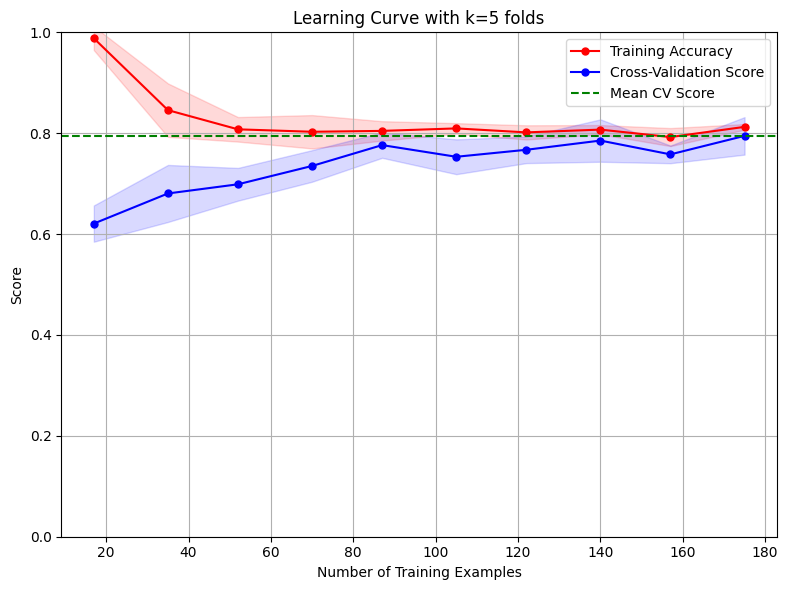

In [109]:

# Define the number of training examples at which to evaluate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train.ravel(), cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='r', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='r')
plt.plot(train_sizes, test_mean, color='b', marker='o', markersize=5, label='Cross-Validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='b')
plt.axhline(y=np.mean(cv_scores), color='g', linestyle='--', label='Mean CV Score')  # Add line for mean CV score
plt.xlabel('Number of Training Examples')
plt.ylabel('Score')
plt.title("Learning Curve with k=5 folds")
plt.legend()
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.grid(True)
plt.tight_layout()
plt.show()

### Loss Validation

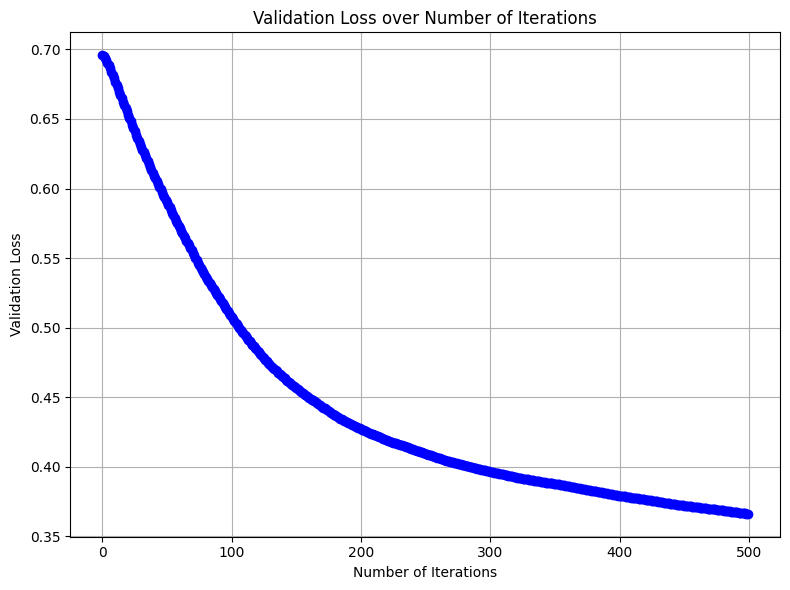

In [110]:
# Get the validation loss from the new model
validation_loss = model.loss_curve_

# Plot the validation loss
plt.figure(figsize=(8, 6))
plt.plot(validation_loss, marker='o', color='b', linewidth=2)
plt.xlabel('Number of Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Number of Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()


### Testing different learning rates and Number of Neurons


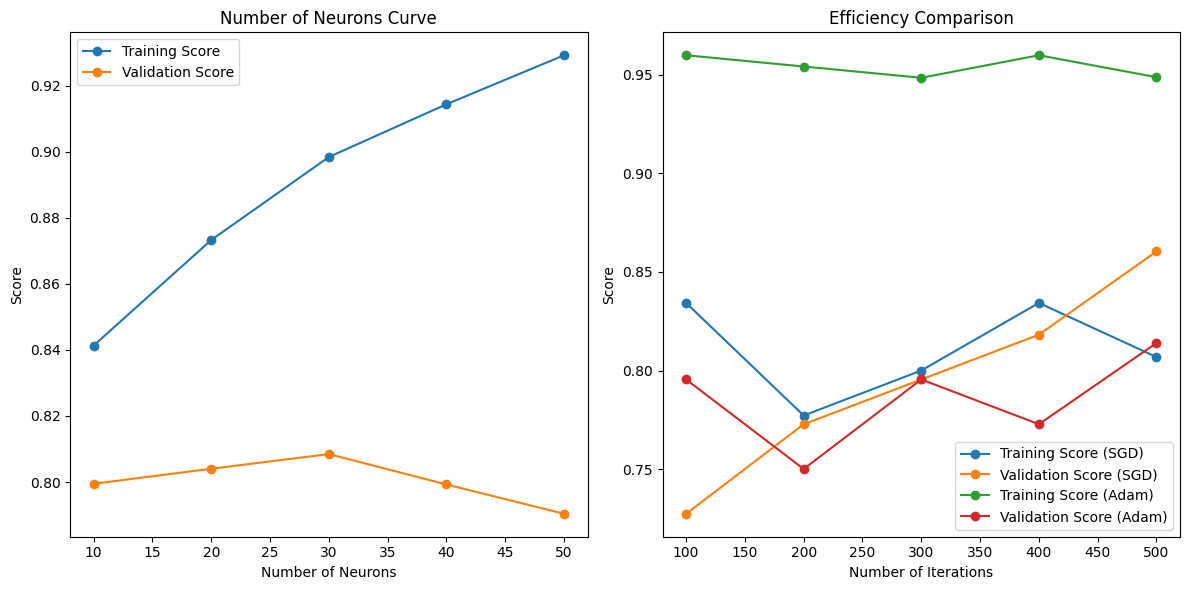

In [130]:
neurons = [10, 20, 30, 40, 50]  # Specify different number of neurons
iterations = [100, 200, 300, 400, 500]  # Specify different number of iterations

# Number of Neurons Curve
param_range_neurons = neurons
train_scores_neurons, test_scores_neurons = validation_curve(
    MLPClassifier(max_iter=500, solver='adam'),
    X_train, y_train.ravel(),
    param_name='hidden_layer_sizes',
    param_range=param_range_neurons,
    cv=5
)

# Cost Function Comparison
solvers = ['sgd', 'adam']
train_scores_solver, test_scores_solver = validation_curve(
    MLPClassifier(max_iter=max(iterations)),
    X_train, y_train.ravel(),
    param_name='solver',
    param_range=solvers,
    cv=5
)

plt.figure(figsize=(12, 6))

# Number of Neurons Curve
plt.subplot(1, 2, 1)
plt.plot(neurons, np.mean(train_scores_neurons, axis=1), marker='o', label='Training Score')
plt.plot(neurons, np.mean(test_scores_neurons, axis=1), marker='o', label='Validation Score')
plt.xlabel('Number of Neurons')
plt.ylabel('Score')
plt.title('Number of Neurons Curve')
plt.legend()

# Efficiency Comparison
plt.subplot(1, 2, 2)
plt.plot(iterations, train_scores_solver[0], marker='o', label='Training Score (SGD)')
plt.plot(iterations, test_scores_solver[0], marker='o', label='Validation Score (SGD)')
plt.plot(iterations, train_scores_solver[1], marker='o', label='Training Score (Adam)')
plt.plot(iterations, test_scores_solver[1], marker='o', label='Validation Score (Adam)')
plt.xlabel('Number of Iterations')
plt.ylabel('Score')
plt.title('Efficiency Comparison')
plt.legend()

plt.tight_layout()
plt.show()


### Hyperparameter Tuning using GridSearchCV

In [112]:
# Hyperparameter tuning using GridSearchCV
# GridSearchCV performs exaustive search over a specified hyperparameter space to find the best model with the highest cross validation score
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (25,), (30,), (10,10), (20,20), (25,25), (30,30)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive']
}
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train.ravel())

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

# Print the accuracy of the best model
print("Best Cross Validation Score: ", grid_search.best_score_)

Best hyperparameters:  {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Cross Validation Score:  0.822198731501057


In [113]:
# Create a new model object with the optimal hyperparameters
best_params = grid_search.best_params_
optimal_model = MLPClassifier(**best_params)
optimal_model .set_params(random_state=42)
optimal_model .set_params(max_iter=500)

# Printing the model object shows the hyperparameter settings
print("\nOptimal Model:\n", optimal_model)

# Train the model on the training data
optimal_model.fit(X_train, y_train.ravel())


Optimal Model:
 MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), max_iter=500,
              random_state=42)


MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), max_iter=500,
              random_state=42)

In [123]:
print("Unregularized and optimized Neural Network")
print("------------------------------------------")

# Predict training set labels
y_pred_train = optimal_model.predict(X_train)
num_iterations = optimal_model.n_iter_

print("Training number of Iterations: ", num_iterations)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print training accuracy
print("Training Accuracy:", train_accuracy)

# Evaluate the model on the test data
y_pred_test = optimal_model.predict(X_test)

# Calculate the accuracy of the model on the test data
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

# Use k-fold cross-validation to estimate the accuracy of the model
cv_scores = cross_val_score(optimal_model, X_train, y_train.ravel(), cv=5, scoring='accuracy')
mean_cv_score = cv_scores.mean()

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", mean_cv_score)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix with labels
print("Confusion Matrix:")
print("                Predicted No    Predicted Yes")
print("Actual No        ", tn, "            ", fp)
print("Actual Yes       ", fn, "             ", tp)

# Generate classification report
cr = classification_report(y_test, y_pred_test)

# Print classification report
print("\nClassification Report:")
print(cr)


Unregularized and optimized Neural Network
------------------------------------------
Training number of Iterations:  500
Training Accuracy: 0.8447488584474886
Test Accuracy: 0.8493150684931506
Cross-validation scores: [0.72727273 0.79545455 0.86363636 0.81818182 0.86046512]
Mean CV score: 0.8130021141649049
Confusion Matrix:
                Predicted No    Predicted Yes
Actual No         34              7
Actual Yes        4               28

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        41
         1.0       0.80      0.88      0.84        32

    accuracy                           0.85        73
   macro avg       0.85      0.85      0.85        73
weighted avg       0.85      0.85      0.85        73



## Learning Curve

/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nudibranch/.local/lib/pyth

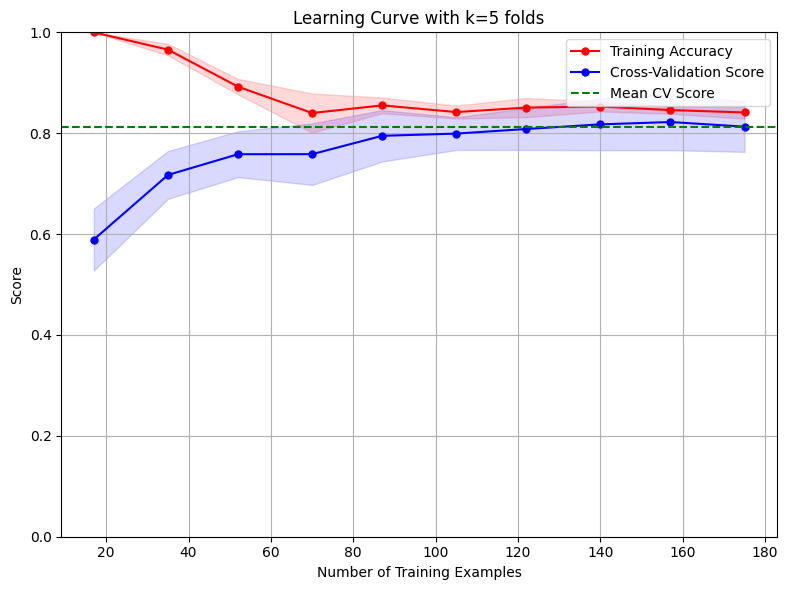

In [115]:

# Define the number of training examples at which to evaluate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    optimal_model, X_train, y_train.ravel(), cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy',n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='r', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='r')
plt.plot(train_sizes, test_mean, color='b', marker='o', markersize=5, label='Cross-Validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='b')
plt.axhline(y=np.mean(cv_scores), color='g', linestyle='--', label='Mean CV Score')  # Add line for mean CV score
plt.xlabel('Number of Training Examples')
plt.ylabel('Score')
plt.title("Learning Curve with k=5 folds")
plt.legend()
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.grid(True)
plt.tight_layout()
plt.show()



## Regularized version of Neural Network

Best Alpha Parameter: 0.0001


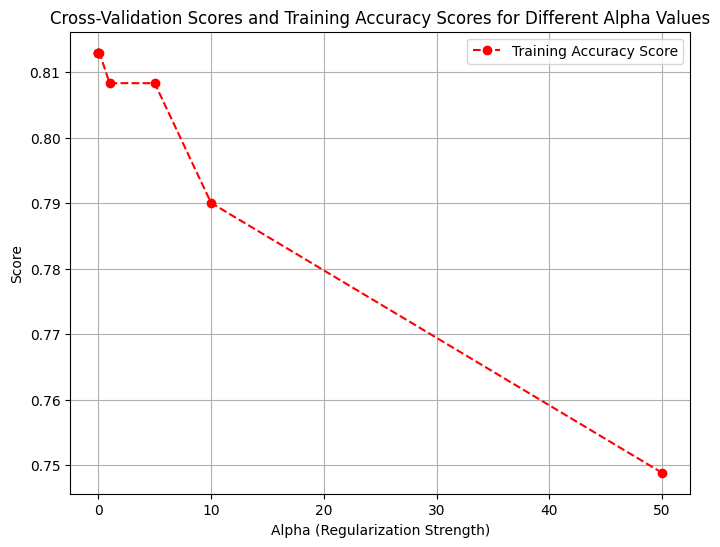

In [116]:

alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50]  # Specify different alpha values

# Create an empty list to store the cross-validation scores and training accuracy scores
cv_scores = []
train_scores = []

# Perform grid search with cross-validation for each alpha value
for alpha in alpha_values:
    # Create the neural network model with two hidden layers, each with 30 neurons and the current alpha value

    temp_model = MLPClassifier(**best_params)
    temp_model.set_params(alpha=alpha)
    temp_model.set_params(random_state=42)
    temp_model.set_params(max_iter=500)
    
    # Perform cross-validation to get the cross-validation scores
    cv_score = np.mean(cross_val_score(temp_model, X_train, y_train, cv=5))
    cv_scores.append(cv_score)
    
    # Perform cross-validation again to get the training accuracy scores
    train_score = np.mean(cross_val_score(temp_model, X_train, y_train, cv=5, scoring='accuracy'))
    train_scores.append(train_score)

best_alpha_index = np.argmax(cv_scores)
best_alpha = alpha_values[best_alpha_index]

print("Best Alpha Parameter:", best_alpha)

# Plot the line graph of cross-validation scores and training accuracy scores
plt.figure(figsize=(8, 6))  # Set the figure size

plt.plot(alpha_values, train_scores, linestyle='--', marker='o', color='r', label='Training Accuracy Score')

plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Score')
plt.title('Cross-Validation Scores and Training Accuracy Scores for Different Alpha Values')
plt.legend()
plt.grid(True)  # Display grid lines
plt.show()




In [117]:
# Create a new model with the best alpha value
best_model = MLPClassifier(**best_params)
best_model.set_params(alpha=best_alpha)
best_model.set_params(random_state=42)
best_model.set_params(max_iter=500)

print("Best Model:\n", best_model)

# Train the new model on the training data
best_model.fit(X_train, y_train.ravel())

Best Model:
 MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), max_iter=500,
              random_state=42)


MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), max_iter=500,
              random_state=42)

In [124]:
print("Regularized and optimized Neural Network")
print("----------------------------------------")

# Predict training set labels
y_pred_train = best_model.predict(X_train)
num_iterations = best_model.n_iter_

print("Training number of Iterations: ", num_iterations)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print training accuracy
print("Training Accuracy:", train_accuracy)

# Evaluate the model on the test data
y_pred_test = best_model.predict(X_test)

# Calculate the accuracy of the model on the test data
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

# Use k-fold cross-validation to estimate the accuracy of the model
cv_scores = cross_val_score(optimal_model, X_train, y_train.ravel(), cv=5, scoring='accuracy')
mean_cv_score = cv_scores.mean()

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", mean_cv_score)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix with labels
print("Confusion Matrix:")
print("                Predicted No    Predicted Yes")
print("Actual No        ", tn, "            ", fp)
print("Actual Yes       ", fn, "             ", tp)

# Generate classification report
cr = classification_report(y_test, y_pred_test)

# Print classification report
print("\nClassification Report:")
print(cr)


Regularized and optimized Neural Network
----------------------------------------
Training number of Iterations:  500
Training Accuracy: 0.8447488584474886
Test Accuracy: 0.8493150684931506
Cross-validation scores: [0.72727273 0.79545455 0.86363636 0.81818182 0.86046512]
Mean CV score: 0.8130021141649049
Confusion Matrix:
                Predicted No    Predicted Yes
Actual No         34              7
Actual Yes        4               28

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        41
         1.0       0.80      0.88      0.84        32

    accuracy                           0.85        73
   macro avg       0.85      0.85      0.85        73
weighted avg       0.85      0.85      0.85        73



### Cost Function

The MLPClassifier in scikit-learn uses the "cross-entropy loss" function, also known as log loss, for both binary and multiclass classification. This loss function measures the difference between predicted probabilities and true class labels. By using the 'sgd' solver (stochastic gradient descent), the MLPClassifier optimizes the model parameters by iteratively updating them based on gradients computed using the backpropagation algorithm. This combination of cross-entropy loss and SGD provides an effective approach for training neural networks in classification tasks.

### ROC Curve

The ROC (Receiver Operating Characteristic) curve is a graphical representation of a binary classification model's performance. It shows the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at different classification thresholds. The curve is created by plotting the TPR against the FPR, with each point on the curve representing a different threshold. The ROC curve provides valuable insights into the model's ability to distinguish between positive and negative instances, and it can help in determining the optimal threshold for classification.

Optimal classification threshold: 0.44


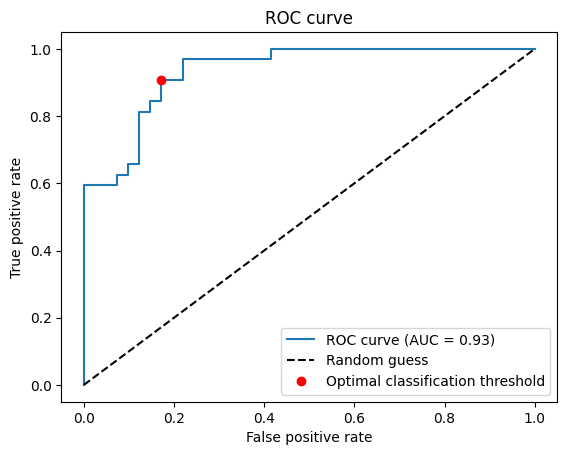

In [119]:
# Get predicted probabilities for the test set
y_prob = best_model.predict_proba(X_test)[:, 1]
# Compute false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate Euclidean distance to the top-left corner for each threshold
dist = np.sqrt(fpr**2 + (1-tpr)**2)
# Find index of threshold with minimum distance
idx = np.argmin(dist)
y_pred = (y_prob >= thresholds[idx]).astype(int)

print('Optimal classification threshold:', round(thresholds[idx], 2))

# Compute AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.plot(fpr[idx], tpr[idx], 'ro', label='Optimal classification threshold')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

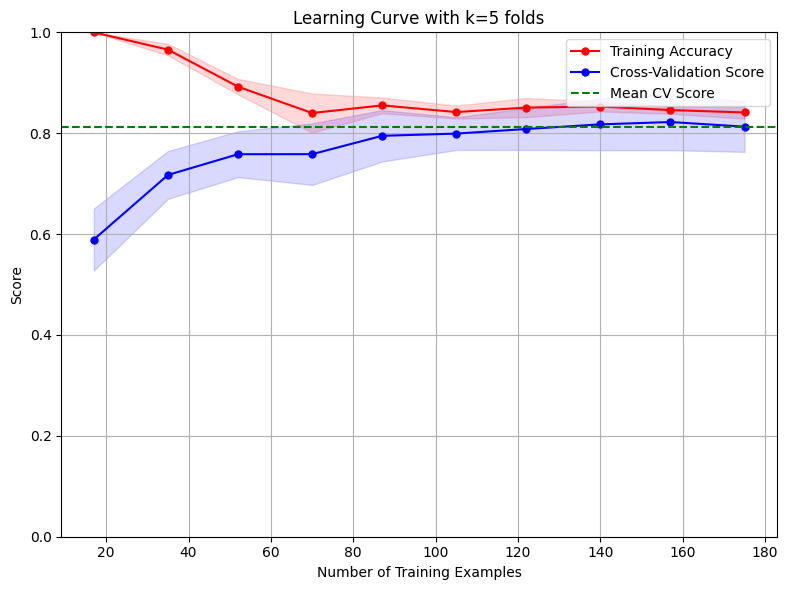

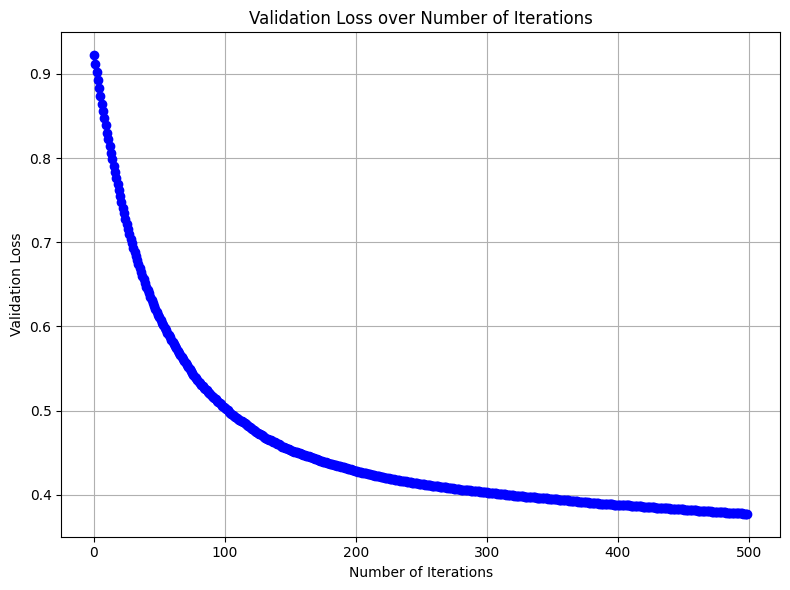

In [120]:


# Define the number of training examples at which to evaluate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    optimal_model, X_train, y_train.ravel(), cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the cross-validation scores
cv_scores = cross_val_score(optimal_model, X_train, y_train.ravel(), cv=5, scoring='accuracy')

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='r', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='r')
plt.plot(train_sizes, test_mean, color='b', marker='o', markersize=5, label='Cross-Validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='b')
plt.axhline(y=np.mean(cv_scores), color='g', linestyle='--', label='Mean CV Score')  # Add line for mean CV score
plt.xlabel('Number of Training Examples')
plt.ylabel('Score')
plt.title("Learning Curve with k=5 folds")
plt.legend()
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.grid(True)
plt.tight_layout()
plt.show()


# Get the validation loss from the new model
validation_loss = best_model.loss_curve_

# Plot the validation loss
plt.figure(figsize=(8, 6))
plt.plot(validation_loss, marker='o', color='b', linewidth=2)
plt.xlabel('Number of Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Number of Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()
